In [1]:
!pip install mplcyberpunk

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import seaborn as sns
import mplcyberpunk
plt.style.use("cyberpunk")

import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

import kagglehub

dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Dataset path:", dataset_path)

# Check structure
for dirname, dirs, files in os.walk(dataset_path):
    print("DIR:", dirname)
    for d in dirs:
        print("   subdir:", d)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Dataset path: /kaggle/input/brain-tumor-mri-dataset
DIR: /kaggle/input/brain-tumor-mri-dataset
   subdir: Training
   subdir: Testing
DIR: /kaggle/input/brain-tumor-mri-dataset/Training
   subdir: pituitary
   subdir: notumor
   subdir: meningioma
   subdir: glioma
DIR: /kaggle/input/brain-tumor-mri-dataset/Training/pituitary
DIR: /kaggle/input/brain-tumor-mri-dataset/Training/notumor
DIR: /kaggle/input/brain-tumor-mri-dataset/Training/meningioma
DIR: /kaggle/input/brain-tumor-mri-dataset/Training/glioma
DIR: /kaggle/input/brain-tumor-mri-dataset/Testing
   subdir: pituitary
   subdir: notumor
   subdir: meningioma
   subdir: glioma
DIR: /kaggle/input/brain-tumor-mri-dataset/Testing/pituitary
DIR: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor
DIR: /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma
DIR: /kaggle/input/brain-tumor-mri-dataset/Testing/glioma


In [3]:
X_data = []
y_data = []
labels = ['glioma','notumor','meningioma','pituitary']
image_size = 224

# Training data
for label in labels:
    folderPath = os.path.join(dataset_path, "Training", label)
    print("Loading from:", folderPath)
    for file in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, file))
        img = cv2.resize(img, (image_size, image_size))
        X_data.append(img)
        y_data.append(label)

# Testing data
for label in labels:
    folderPath = os.path.join(dataset_path, "Testing", label)
    print("Loading from:", folderPath)
    for file in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, file))
        img = cv2.resize(img, (image_size, image_size))
        X_data.append(img)
        y_data.append(label)

X_data = np.array(X_data)
y_data = np.array(y_data)

print("✅ Data loaded:", X_data.shape, y_data.shape)


Loading from: /kaggle/input/brain-tumor-mri-dataset/Training/glioma
Loading from: /kaggle/input/brain-tumor-mri-dataset/Training/notumor
Loading from: /kaggle/input/brain-tumor-mri-dataset/Training/meningioma
Loading from: /kaggle/input/brain-tumor-mri-dataset/Training/pituitary
Loading from: /kaggle/input/brain-tumor-mri-dataset/Testing/glioma
Loading from: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor
Loading from: /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma
Loading from: /kaggle/input/brain-tumor-mri-dataset/Testing/pituitary
✅ Data loaded: (7023, 224, 224, 3) (7023,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5618, 224, 224, 3)
X_test shape: (1405, 224, 224, 3)
y_train shape: (5618,)
y_test shape: (1405,)


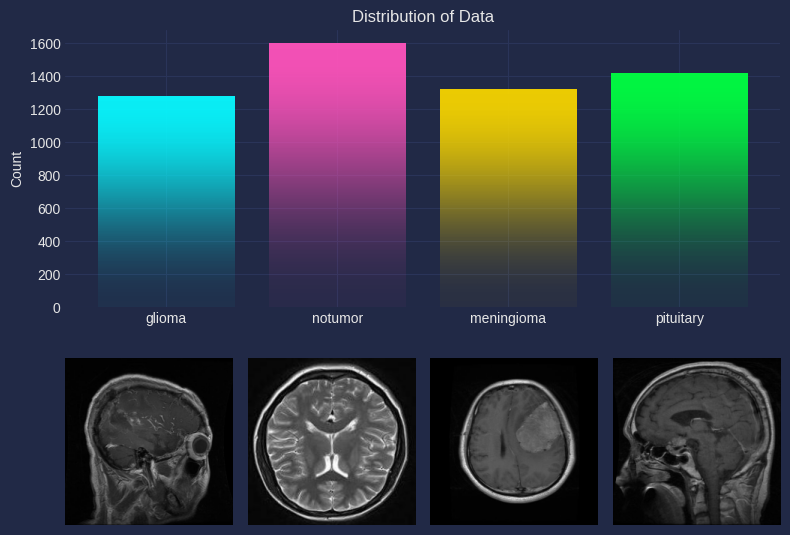

In [5]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Data')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# If y_data is still strings, convert to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_int = le.fit_transform(y_data)

# Train (80%), Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_data, y_int, test_size=0.2, stratify=y_int, random_state=42
)

# Validation (10%) + Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("✅ Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

✅ Train: (5618, 224, 224, 3)  Val: (702, 224, 224, 3)  Test: (703, 224, 224, 3)


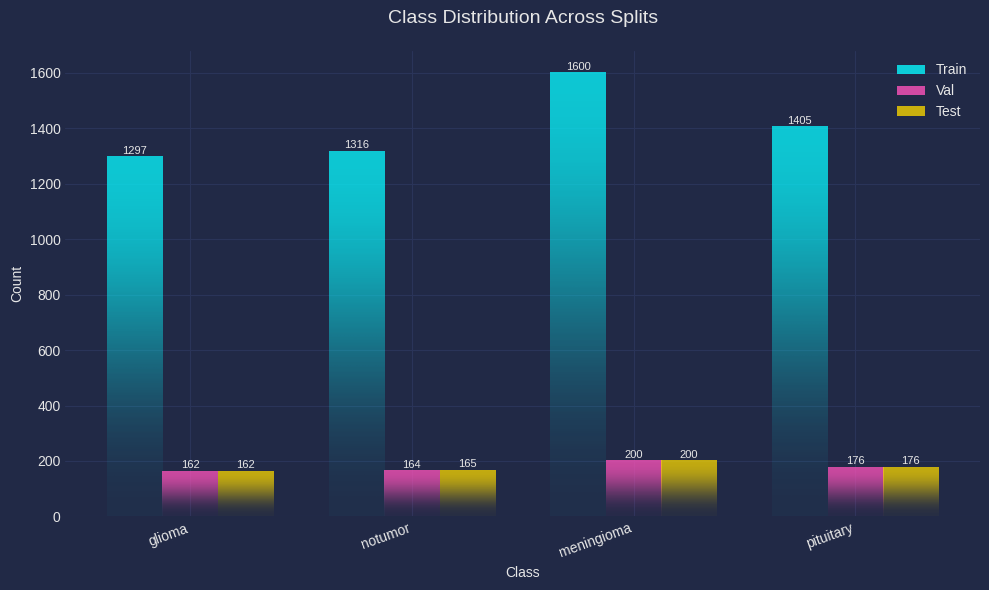

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

try:
    class_names = labels
except NameError:
    class_names = [f"class_{i}" for i in range(4)]

def normalize_labels(y):
    y = np.asarray(y)
    if y.ndim == 2 and y.shape[1] == len(class_names):
        return np.argmax(y, axis=1)
    if y.dtype.kind in ("U", "S", "O"):
        mapping = {name: i for i, name in enumerate(class_names)}
        return np.array([mapping[str(v)] for v in y])
    return y.astype(int)

# Normalize label formats
ytr = normalize_labels(y_train)
yval = normalize_labels(y_val)
yte = normalize_labels(y_test)

# Compute class counts per split
train_counts = np.bincount(ytr, minlength=len(class_names))
val_counts   = np.bincount(yval, minlength=len(class_names))
test_counts  = np.bincount(yte, minlength=len(class_names))

# Create grouped bar chart
x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, train_counts, width, label='Train', alpha=0.8)
bars2 = ax.bar(x, val_counts, width, label='Val', alpha=0.8)
bars3 = ax.bar(x + width, test_counts, width, label='Test', alpha=0.8)

# Cyberpunk glow effect
mplcyberpunk.add_bar_gradient(bars=bars1)
mplcyberpunk.add_bar_gradient(bars=bars2)
mplcyberpunk.add_bar_gradient(bars=bars3)

# Annotate counts
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 5,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Labels and title
ax.set_title("Class Distribution Across Splits", fontsize=14, pad=20)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=20, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [8]:
# One-hot encoding (manual way)

# Train
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(class_names[i] if isinstance(i, (np.int64, int)) else i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))

# Validation
y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(class_names[i] if isinstance(i, (np.int64, int)) else i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(labels))

# Test
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(class_names[i] if isinstance(i, (np.int64, int)) else i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))

print("✅ Shapes after one-hot encoding:")
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)


✅ Shapes after one-hot encoding:
y_train: (5618, 4)
y_val: (702, 4)
y_test: (703, 4)


In [9]:
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow as tf

image_size = 224
num_classes = 4

# 1) Load base
efficientnetB0 = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

# Freeze base for initial training
efficientnetB0.trainable = False

# 2) Build head (keeps your structure)
x = efficientnetB0.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=efficientnetB0.input, outputs=outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
checkpoint = callbacks.ModelCheckpoint("best_efficientnetb0.h5", monitor="val_loss", save_best_only=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
tensorboard = TensorBoard(log_dir="logs")


In [11]:
y_train_onehot = y_train

history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr, early]
)


Epoch 1/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6725 - loss: 0.8279
Epoch 1: val_loss improved from inf to 0.35458, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 226ms/step - accuracy: 0.6731 - loss: 0.8266 - val_accuracy: 0.8789 - val_loss: 0.3546 - learning_rate: 1.0000e-04
Epoch 2/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8819 - loss: 0.3454
Epoch 2: val_loss improved from 0.35458 to 0.27975, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8818 - loss: 0.3453 - val_accuracy: 0.8960 - val_loss: 0.2797 - learning_rate: 1.0000e-04
Epoch 3/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8925 - loss: 0.2944
Epoch 3: val_loss improved from 0.27975 to 0.24933, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8925 - loss: 0.2943 - val_accuracy: 0.9088 - val_loss: 0.2493 - learning_rate: 1.0000e-04
Epoch 4/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9071 - loss: 0.2545
Epoch 4: val_loss improved from 0.24933 to 0.22639, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9071 - loss: 0.2544 - val_accuracy: 0.9188 - val_loss: 0.2264 - learning_rate: 1.0000e-04
Epoch 5/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9164 - loss: 0.2345
Epoch 5: val_loss improved from 0.22639 to 0.21777, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9165 - loss: 0.2344 - val_accuracy: 0.9188 - val_loss: 0.2178 - learning_rate: 1.0000e-04
Epoch 6/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9308 - loss: 0.1993
Epoch 6: val_loss improved from 0.21777 to 0.19532, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9307 - loss: 0.1993 - val_accuracy: 0.9231 - val_loss: 0.1953 - learning_rate: 1.0000e-04
Epoch 7/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9378 - loss: 0.1733
Epoch 7: val_loss improved from 0.19532 to 0.17736, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9378 - loss: 0.1734 - val_accuracy: 0.9345 - val_loss: 0.1774 - learning_rate: 1.0000e-04
Epoch 8/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9429 - loss: 0.1714
Epoch 8: val_loss improved from 0.17736 to 0.17544, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9429 - loss: 0.1713 - val_accuracy: 0.9316 - val_loss: 0.1754 - learning_rate: 1.0000e-04
Epoch 9/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9484 - loss: 0.1550
Epoch 9: val_loss improved from 0.17544 to 0.16073, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9484 - loss: 0.1551 - val_accuracy: 0.9430 - val_loss: 0.1607 - learning_rate: 1.0000e-04
Epoch 10/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9509 - loss: 0.1446
Epoch 10: val_loss improved from 0.16073 to 0.15895, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9509 - loss: 0.1446 - val_accuracy: 0.9444 - val_loss: 0.1589 - learning_rate: 1.0000e-04
Epoch 11/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9566 - loss: 0.1293
Epoch 11: val_loss did not improve from 0.15895
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9565 - loss: 0.1293 - val_accuracy: 0.9373 - val_loss: 0.1619 - learning_rate: 1.0000e-04
Epoch 12/12
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9518 - loss: 0.1352
Epoch 12: val_loss improved from 0.15895 to 0.14066, saving model to best_efficientnetb0.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9519 - loss: 0.1351 - val_accuracy: 0.9487 - val_loss: 0.1407 - learning_rate: 1.0000e-04


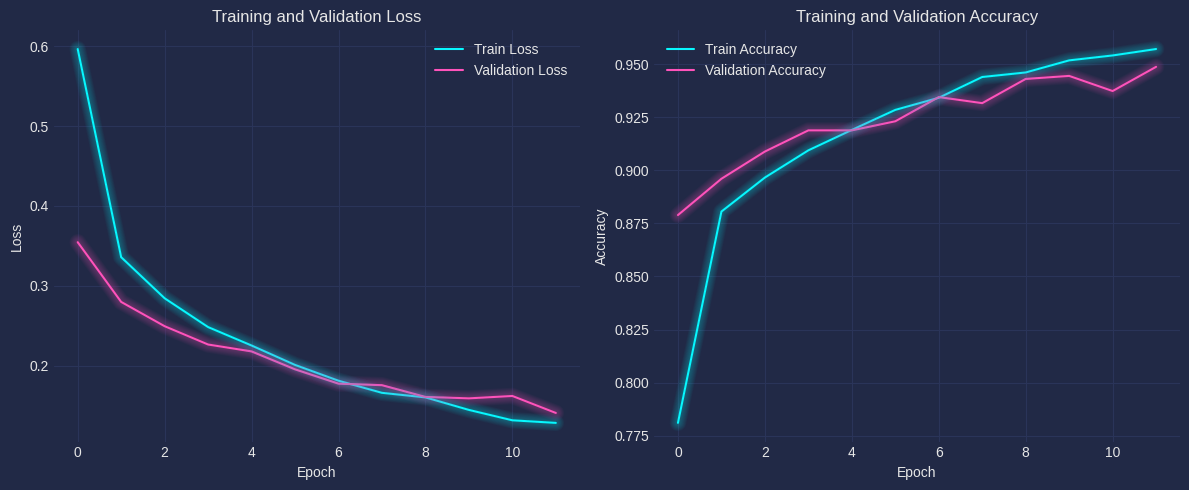

In [12]:

# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step


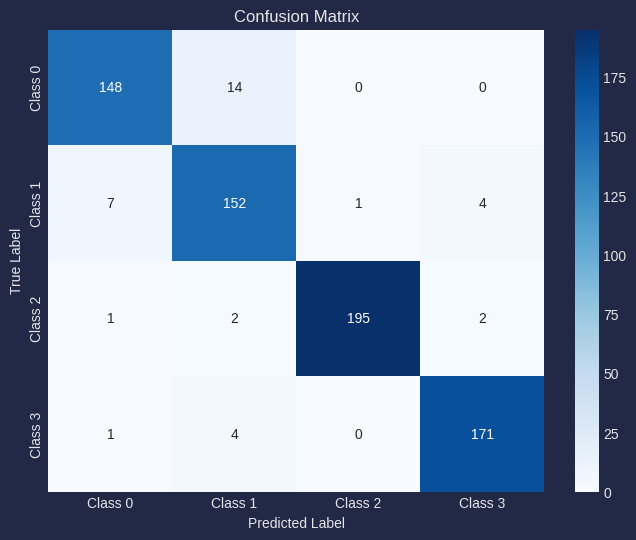


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.94      0.91      0.93       162
     Class 1       0.88      0.93      0.90       164
     Class 2       0.99      0.97      0.98       200
     Class 3       0.97      0.97      0.97       176

    accuracy                           0.95       702
   macro avg       0.95      0.95      0.95       702
weighted avg       0.95      0.95      0.95       702



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Predict on validation set
y_val_pred_probs = model.predict(X_val, batch_size=32)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)   # predicted labels
y_val_true = np.argmax(y_val, axis=1)              # true labels (one-hot -> class index)

# 2. Build confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# 3. Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 4. Print classification report
print("\nClassification Report:\n")
print(classification_report(y_val_true, y_val_pred, target_names=[f"Class {i}" for i in range(num_classes)]))


Predicted label: glioma
Actual label: glioma
Confidence: 95.75%



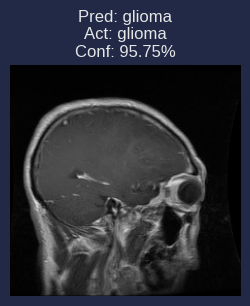

Predicted label: pituitary
Actual label: pituitary
Confidence: 97.58%



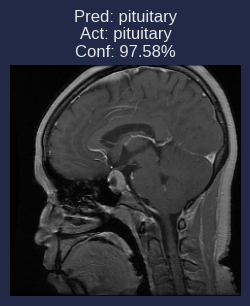

Predicted label: notumor
Actual label: notumor
Confidence: 99.16%



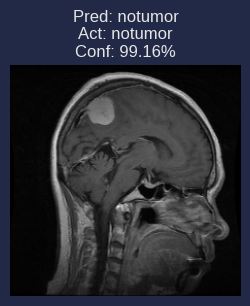

Predicted label: meningioma
Actual label: meningioma
Confidence: 99.98%



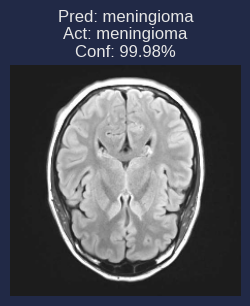

Predicted label: meningioma
Actual label: meningioma
Confidence: 95.15%



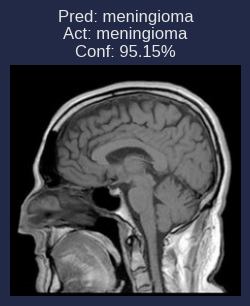

Predicted label: pituitary
Actual label: pituitary
Confidence: 99.77%



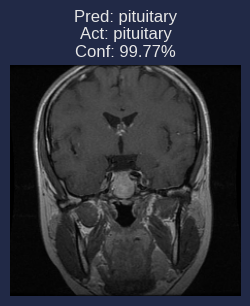

Predicted label: meningioma
Actual label: meningioma
Confidence: 84.18%



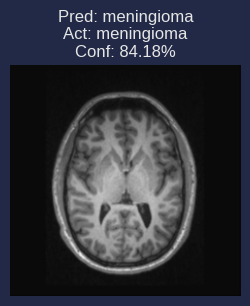

Predicted label: notumor
Actual label: pituitary
Confidence: 60.72%



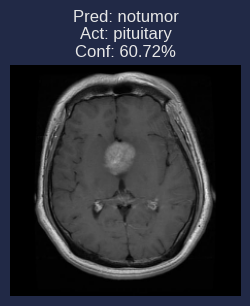

Predicted label: meningioma
Actual label: meningioma
Confidence: 99.44%



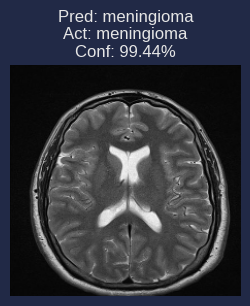

Predicted label: pituitary
Actual label: pituitary
Confidence: 99.11%



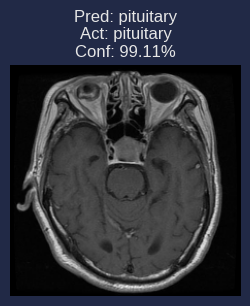

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Randomly pick 10 indices
random_indices = np.random.choice(len(X_test), 10, replace=False)

for idx in random_indices:
    random_img = X_test[idx]

    # Resize to match EfficientNetB0 input
    img_resized = cv2.resize(random_img, (224, 224))

    # Predict
    predictions = model.predict(img_resized.reshape(1, 224, 224, 3), verbose=0)

    # Get predicted class and confidence
    predicted_class = np.argmax(predictions)
    predicted_label = labels[predicted_class]
    confidence = predictions[0][predicted_class]

    # Get actual label
    actual_index = y_test[idx]
    actual_class = np.argmax(actual_index)
    actual_label = labels[actual_class]

    # Print results
    print(f"\033[94mPredicted label: {predicted_label}\033[0m")
    print(f"\033[92mActual label: {actual_label}\033[0m")
    print(f"\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")

    # Show image
    plt.figure(figsize=(3, 3))
    plt.imshow(random_img)  # show original (not resized) for clarity
    plt.axis("off")
    plt.title(f"Pred: {predicted_label}\nAct: {actual_label}\nConf: {confidence*100:.2f}%")
    plt.show()


In [15]:
import tensorflow as tf
import numpy as np
import cv2

# --- Grad-CAM heatmap function ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get model layers
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradient of top predicted class with respect to last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute mean intensity of gradients per feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply feature maps by their importance weights
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to 0–1 range
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# --- Overlay function ---
def overlay_heatmap_on_image(image, heatmap, alpha=0.4):
    # Resize heatmap to match image
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    overlay = cv2.addWeighted(image.astype(np.uint8), 1 - alpha, heatmap, alpha, 0)
    return overlay


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


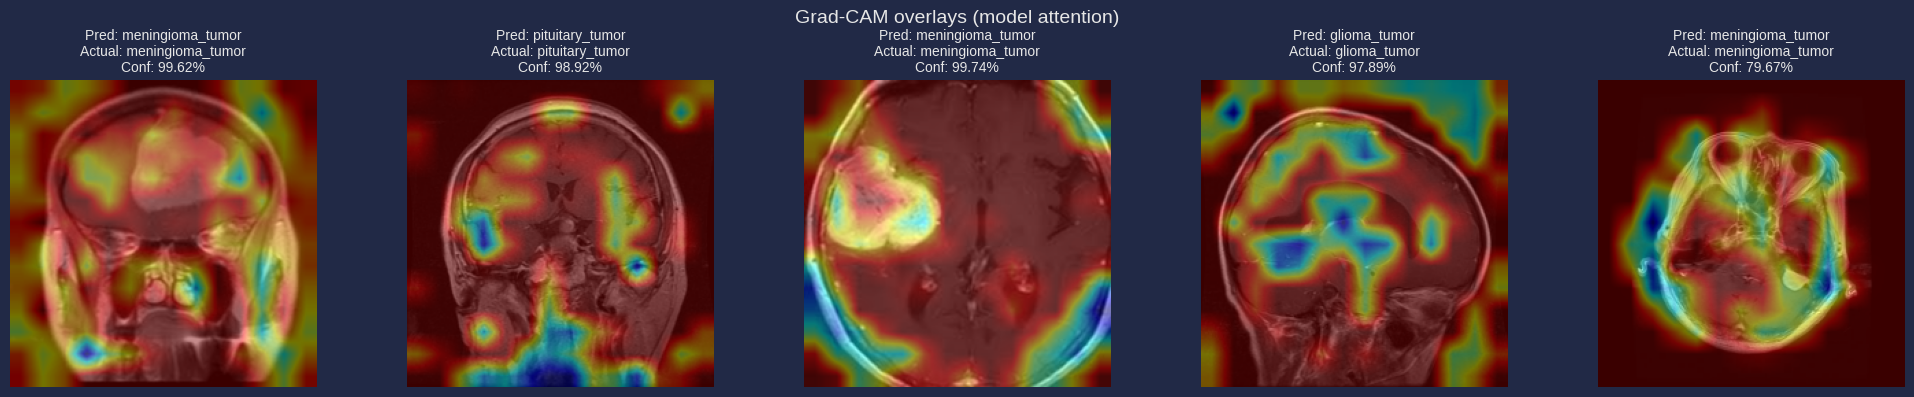

In [16]:

from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess

# --- Prepare robust integer label array from y_test ---
y_test_arr = np.asarray(y_test)

if y_test_arr.ndim == 2 and y_test_arr.shape[1] == len(labels):
    # One-hot encoded
    y_true_indices = np.argmax(y_test_arr, axis=1)
elif y_test_arr.dtype.kind in ("U", "S", "O"):
    # String labels
    mapping = {name: i for i, name in enumerate(labels)}
    y_true_indices = np.array([mapping.get(str(v), 0) for v in y_test_arr])
else:
    # Already numeric
    y_true_indices = y_test_arr.astype(int)


#  Set Grad-CAM config
input_h, input_w = 224, 224               # match your model input size
last_conv_name = "block6a_expand_conv"  # ✅ Add this line here
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Grad-CAM visualization code
N = 5
indices = np.random.choice(len(X_test), size=min(N, len(X_test)), replace=False)
fig, axes = plt.subplots(1, len(indices), figsize=(4 * len(indices), 4))
if len(indices) == 1:
    axes = [axes]

for ax, idx in zip(axes, indices):
    orig = X_test[idx]
    img_resized = cv2.resize(orig, (input_w, input_h))
    img_proc = img_resized.astype(np.float32)
    if img_proc.max() <= 1.0:
        img_proc = img_proc * 255.0
    img_proc = preprocess(img_proc)
    img_batch = np.expand_dims(img_proc, axis=0)

    preds = model.predict(img_batch, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = labels[pred_idx]
    confidence = preds[0][pred_idx] * 100.0

    true_idx = int(y_true_indices[idx])
    true_label = labels[true_idx]

    heatmap = make_gradcam_heatmap(img_batch, model, last_conv_name)
    overlay = overlay_heatmap_on_image(img_resized, heatmap, alpha=0.45)

    ax.imshow(overlay.astype(np.uint8))
    ax.axis('off')
    ax.set_title(f"Pred: {pred_label}\nActual: {true_label}\nConf: {confidence:.2f}%", fontsize=10)

plt.suptitle("Grad-CAM overlays (model attention)", fontsize=14)
plt.tight_layout()
plt.show()


In [20]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [21]:
# Create a folder inside Drive (optional)
save_dir = "/content/drive/MyDrive/Brain_Tumor_Models"
import os
os.makedirs(save_dir, exist_ok=True)

# Save the model in Keras HDF5 format (.h5)
model.save(os.path.join(save_dir, "best_efficientnetb0.h5"))

print("✅ Model saved successfully at:", os.path.join(save_dir, "best_efficientnetb0.h5"))


✅ Model saved successfully at: /content/drive/MyDrive/Brain_Tumor_Models/best_efficientnetb0.h5


In [1]:
from google.colab import drive
from tensorflow.keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')

# Path to your saved model in Drive
model_path = "/content/drive/MyDrive/Brain_Tumor_Models/best_efficientnetb0.h5"

# Load model
model = load_model(model_path)
print("✅ Model loaded successfully from:", model_path)


Mounted at /content/drive


✅ Model loaded successfully from: /content/drive/MyDrive/Brain_Tumor_Models/best_efficientnetb0.h5


In [18]:
from google.colab import files

# Upload multiple images (Ctrl or Shift + Click to select many)
uploaded = files.upload()

# List uploaded file names
uploaded_files = list(uploaded.keys())
print(f"📂 Uploaded {len(uploaded_files)} files:")
for f in uploaded_files:
    print(" -", f)


KeyboardInterrupt: 

/tmp/ipython-input-1421045860.py:34: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


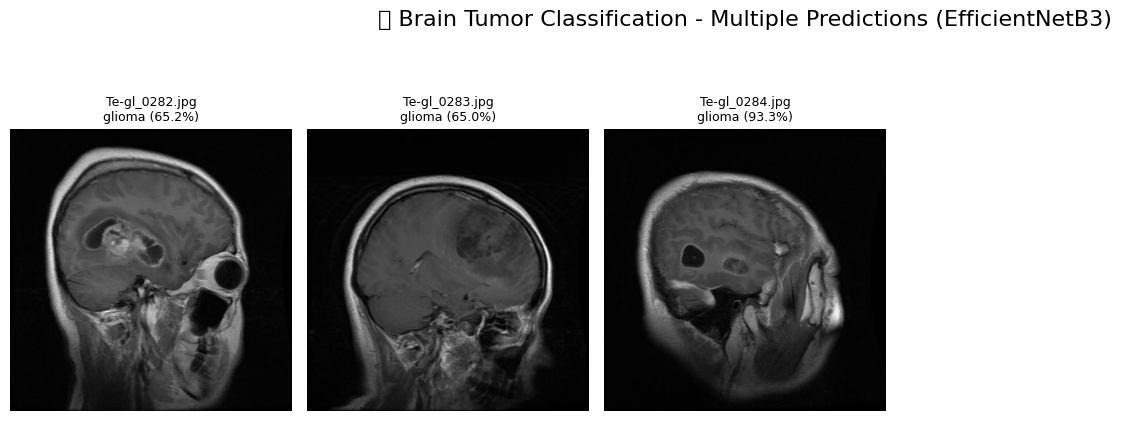

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import os

# Define labels (same as used during training)
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot predictions
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(uploaded_files):
    # Load and preprocess
    img = image.load_img(img_path, target_size=(224, 224))  # EfficientNetB3 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = labels[pred_idx]
    confidence = preds[0][pred_idx] * 100

    # Display image
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(f"{os.path.basename(img_path)}\n{pred_label} ({confidence:.1f}%)", fontsize=9)
    plt.axis("off")

plt.suptitle("🧠 Brain Tumor Classification - Multiple Predictions (EfficientNetB3)", fontsize=16)
plt.tight_layout()
plt.show()
